In [1]:
import numpy as np
import json

from collections import defaultdict

from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow import keras

%matplotlib inline

In [2]:
def to_flat(a):
    return a.reshape(a.shape[0], a.shape[1] * a.shape[2])

def to_one_hot(a, n):
    result = np.zeros(shape=(a.shape[0], n))
    result[np.arange(len(a)), a] = 1
    return result

def load_images(path, n):
    labels, x, y = [], [], []
    for i, d in enumerate(Path(path).iterdir()):
        labels.append(d.name)
        print(f'Loading {str(d)} ', end='')
        for j, f in zip(range(n), d.iterdir()):
            try:
                with Image.open(f) as img:
                    x.append(np.array(img))
                    y.append(i)
            except OSError:
                pass
            if j % 1000 == 0:
                print('.', end='')
        print()
    return np.array(labels), np.array(x), np.array(y)

def remove_duplicates(img_train, labels_train, img_test):
    img_new, labels_new = [], []
    test_set = {e.tostring() for e in img_test}
    for i, (x, y) in enumerate(zip(img_train, labels_train)):
        if x.tostring() not in test_set:
            img_new.append(x)
            labels_new.append(y)
            
    print(f'Removed {img_train.shape[0] - len(img_new)} duplicated images')
    return np.array(img_new), np.array(labels_new)

def load_data(path='data/notMNIST/', use_cache=True):
    train_file = Path(path) / 'train.npz'
    test_file = Path(path) / 'test.npz'
    
    if train_file.exists() and test_file.exists() and use_cache:
        print('Loading cached arrays ...')
        labels, img_train, labels_train = np.load(train_file).values()
        labels, img_test, labels_test = np.load(test_file).values()

    else:
        labels, img_train, labels_train = load_images('data/notMNIST/large/', 10000000)
        labels, img_test, labels_test = load_images('data/notMNIST/small/', 10000)
        np.savez(train_file, labels, img_train, labels_train)
        np.savez(test_file, labels, img_test, labels_test)
        
    img_train, labels_train = remove_duplicates(img_train, labels_train, img_test)
    return labels, img_train, labels_train, img_test, labels_test

In [3]:
%%time
labels, img_train, labels_train, img_test, labels_test = load_data()

Loading cached arrays ...
Removed 12213 duplicated images
CPU times: user 1.79 s, sys: 622 ms, total: 2.41 s
Wall time: 2.61 s


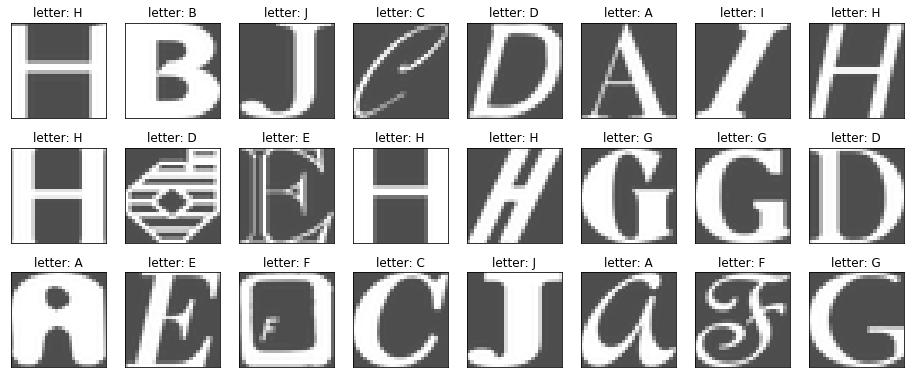

In [4]:
rows = 3
cols = 8
fig = plt.figure(figsize=(16, 6.5))
for i in range(1, cols * rows + 1):
    ax = fig.add_subplot(rows, cols, i)
    ax.set_xticks([])
    ax.set_yticks([])
    
    j = np.random.randint(0, labels_test.shape[0] - 1)
    ax.set_title(f"letter: {labels[labels_test[j]]}")
    plt.imshow(img_test[j], cmap='gray', alpha=0.7)

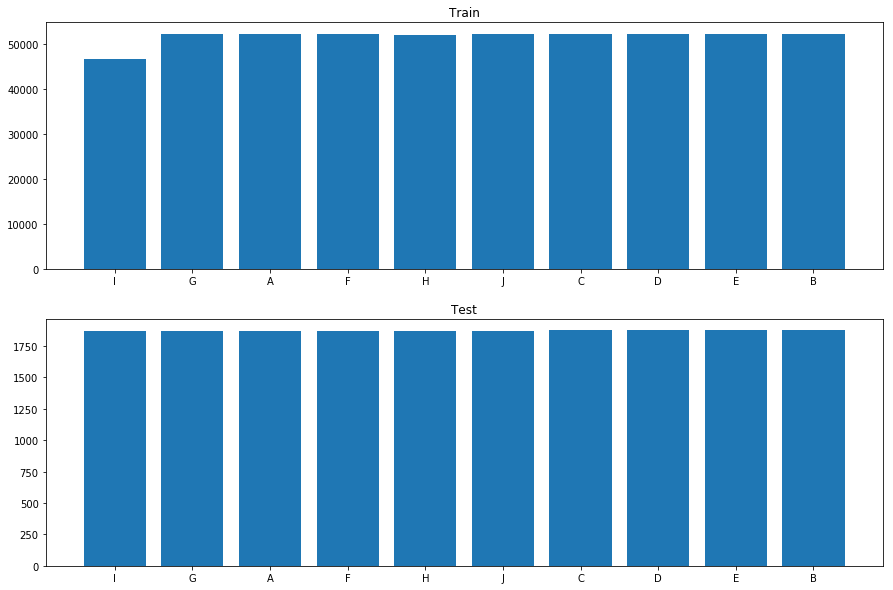

In [5]:
def show_balance(title, ax, a, labels):
    counts = defaultdict(int)
    for e in a:
        counts[labels[e]] += 1
        
    ax.bar(counts.keys(), counts.values())
    ax.set_title(title)
    
fig = plt.figure(figsize=(15, 10))
show_balance("Train", fig.add_subplot(2, 1, 1), labels_train, labels)
show_balance("Test", fig.add_subplot(2, 1, 2), labels_test, labels)

In [320]:
class NotMNISTClassifier(object):
    
    def __init__(self, labels, x_train, y_train, x_test, y_test):
        self.labels = labels
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
    
    def train(self):
        pass
    
    def test(self):
        pass

In [321]:
class LogisticRegression(NotMNISTClassifier):
    
    def __init__(self, labels, x_train, y_train, x_test, y_test):
        super(LogisticRegressionClassifier, self).__init__(labels, x_train, y_train, x_test, y_test)
        self.x_train = to_flat(x_train)
        self.x_test = to_flat(x_test)

        self.lr = None
        self.y_pred = None
        self.results = {"Logistic Regression": []}
        
    def train(self):
        ns = [int(2 ** n) for n in np.arange(7, np.ceil(np.log2(len(self.x_train) / 10)) + 1)]
        for n in ns:
            indices = np.arange(len(self.x_train))
            if n < len(self.x_train):
                indices = np.random.choice(indices, n, replace=False)

            self.lr = SGDClassifier(loss='log', tol=1e-4, early_stopping=True)
            self.lr.fit(self.x_train[indices], self.y_train[indices])

            self.y_pred = self.lr.predict(self.x_test)
            acc = accuracy_score(self.y_test, self.y_pred)

            self.results["Logistic Regression"][n] = acc
            print(f"n = {n}, accuracy = {acc:.2f}, iterations = {self.lr.n_iter_}")
        
    def test(self):
        self.y_pred = self.lr.predict(self.x_test)
        acc = accuracy_score(self.y_test, self.y_pred)
        return acc
    
    def plot_results(self):
        plt.rcParams['font.size'] = 14
        plt.rcParams['font.weight'] = 100

        fig = plt.figure(figsize=(15, 6))
        for i, ((model_name, result), marker) in enumerate(zip(self.results.items(), ['o', 's', '^'])):
            ax = fig.add_subplot(len(self.results), 1, i + 1)

            ax.set(xlabel='Training Set Size', ylabel='Accuracy')
            ax.set_xscale('log')
            ax.set_yticks(np.arange(0.5, 1.04, 0.05))
            ax.axhline(1, ls='--', color='purple', linewidth=2, alpha=0.5)

            x = [int(n) for n in result.keys()]
            y = list(result.values())

            ax.plot(x, y, '-{}'.format(marker), markersize=8, label=model_name, linewidth=2)
            ax.set_xticks(x[::2])
            ax.set_xticklabels(x[::2])

            ax.grid()
            ax.legend(loc='lower center')

        plt.show()
        

In [322]:
logistic_regression_model = LogisticRegressionClassifier(labels, img_train, labels_train, img_test, labels_test)
logistic_regression_model.train()

n = 128, accuracy = 0.68, iterations = 8
n = 256, accuracy = 0.76, iterations = 9
n = 512, accuracy = 0.81, iterations = 6
n = 1024, accuracy = 0.78, iterations = 6
n = 2048, accuracy = 0.81, iterations = 6
n = 4096, accuracy = 0.76, iterations = 8
n = 8192, accuracy = 0.76, iterations = 6
n = 16384, accuracy = 0.79, iterations = 7


KeyboardInterrupt: 

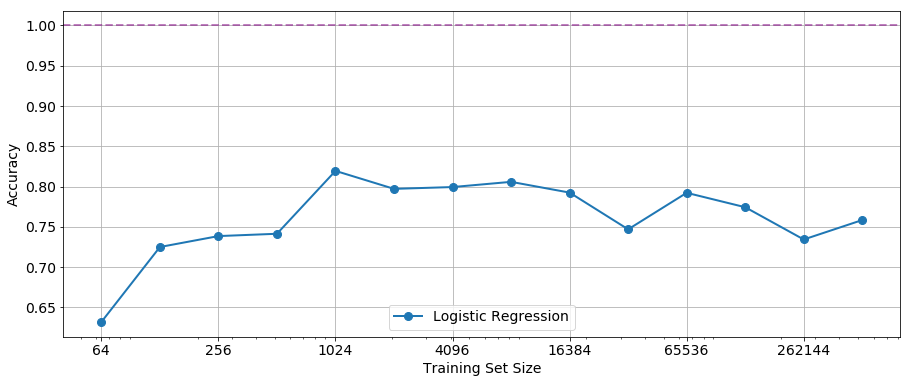

In [323]:
logistic_regression_model.plot_results()

In [324]:
import tensorflow as tf

In [401]:
class FullyConnectedNN(NotMNISTClassifier):
    
    hidden_layer_size = 256
    learning_rate = 0.001
    
    with_regularization=False 
    with_dropouts=False
    adaptive_lr=False
    
    def __init__(self, labels, x_train, y_train, x_test, y_test):
        super(FullyConnectedNN, self).__init__(labels, x_train, y_train, x_test, y_test)
        self.x_train = to_flat(x_train)
        self.y_train = to_one_hot(y_train, len(labels))
        self.x_test = to_flat(x_test)
        self.y_test = to_one_hot(y_test, len(labels))
        
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
            self.x_train, 
            self.y_train, 
            test_size=0.1
        )
        
        self.init_nn()
        self.session = tf.Session()
        
        self.results = {}
    
    def init_nn(self):
        self.input = tf.placeholder(tf.float32, [None, self.x_train.shape[1]], name='inputs')
        self.expected = tf.placeholder(tf.float32, [None, self.y_train.shape[1]], name='expected')
        self.dropout_rate = tf.placeholder(tf.float32)
        
        self.w = {}
        self.b = {}
        
        self.w[0] = tf.Variable(tf.truncated_normal((self.x_train.shape[1], self.hidden_layer_size), stddev=0.05))
        self.b[0] = tf.Variable(tf.zeros(self.hidden_layer_size))
        hidden = tf.nn.relu(tf.matmul(self.input, self.w[0]) + self.b[0])
        
        if self.with_dropouts:
            hidden = tf.nn.dropout(hidden, rate=self.dropout_rate)
        
        self.w[1] = tf.Variable(tf.truncated_normal((self.hidden_layer_size, self.hidden_layer_size), stddev=0.05))
        self.b[1] = tf.Variable(tf.zeros(self.hidden_layer_size))
        hidden = tf.nn.relu(tf.matmul(hidden, self.w[1]) + self.b[1])
        
        if self.with_dropouts:
            hidden = tf.nn.dropout(hidden, rate=self.dropout_rate)
        
        self.w[2] = tf.Variable(tf.truncated_normal((self.hidden_layer_size, self.y_train.shape[1]), stddev=0.05))
        self.b[2]  = tf.Variable(tf.zeros(self.y_train.shape[1]))
        self.logits = tf.matmul(hidden, self.w[2]) + self.b[2]
        self.predicted = tf.nn.softmax(self.logits)
                
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=self.logits, 
                labels=self.expected
            )
        )
        if self.with_regularization:
            regularizers = tf.nn.l2_loss(self.w[0]) + tf.nn.l2_loss(self.w[1]) + tf.nn.l2_loss(self.w[2])
            self.loss = tf.reduce_mean(self.loss + 0.005 * regularizers)
        
        if self.adaptive_lr:
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        else:
            self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
            
        self.optimizer = self.optimizer.minimize(self.loss)
        
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(self.predicted, 1), tf.argmax(self.expected, 1)),
                tf.float32,
            )
        )
        
    def train(self, epochs=50, batch_size=5000):
        indices = np.arange(self.x_train.shape[0])
        with self.session.as_default():
            self.session.run(tf.local_variables_initializer())
            self.session.run(tf.global_variables_initializer())

            for epoch in range(epochs):
                print(f"Epoch {epoch:<4} [", end='')
                self.results[epoch] = {}

                np.random.shuffle(indices)
                k = self.x_train.shape[0] // batch_size // 20 + 1
                for i, j in enumerate(np.arange(0, indices.shape[0], batch_size)):
                    _, loss = self.session.run(
                        (self.optimizer, self.loss),
                        feed_dict={
                            self.input: self.x_train[indices[j:j+batch_size]],
                            self.expected: self.y_train[indices[j:j+batch_size]],
                            self.dropout_rate: 0.2,
                        }
                    )
                    if i % k == 0:
                        print('.', end='')

                print(']    ', end='')

                feed_dict = {
                    self.input: self.x_val, 
                    self.expected: self.y_val, 
                    self.dropout_rate: 0
                }
                
                val_loss = self.loss.eval(feed_dict=feed_dict)
                val_acc = self.accuracy.eval(feed_dict=feed_dict)
                print(f"val_loss = {val_loss:.6f}, val_acc = {val_acc:.6f}")
                
                self.results[epoch]['val_loss'] = val_loss
                self.results[epoch]['val_acc'] = val_acc
                
    def test(self):
        with self.session.as_default():
            return self.accuracy.eval({
                self.input: self.x_test,
                self.expected: self.y_test,
                self.dropout_rate: 0
            })

In [402]:
%%time
fc_nn = FullyConnectedNN(labels, img_train, labels_train, img_test, labels_test)
fc_nn.train()
print("Max Accuracy: ", fc_nn.test())

Epoch 0    [...................]    val_loss = 1.880601, val_acc = 0.701147
Epoch 1    [...................]    val_loss = 1.282855, val_acc = 0.724575
Epoch 2    [...................]    val_loss = 1.048228, val_acc = 0.746745
Epoch 3    [...................]    val_loss = 0.927975, val_acc = 0.760403
Epoch 4    [...................]    val_loss = 0.861176, val_acc = 0.769631
Epoch 5    [...................]    val_loss = 0.815255, val_acc = 0.776344
Epoch 6    [...................]    val_loss = 0.780327, val_acc = 0.782593
Epoch 7    [...................]    val_loss = 0.758931, val_acc = 0.784721
Epoch 8    [...................]    val_loss = 0.742667, val_acc = 0.788609
Epoch 9    [...................]    val_loss = 0.730741, val_acc = 0.789905
Epoch 10   [...................]    val_loss = 0.714373, val_acc = 0.793658
Epoch 11   [...................]    val_loss = 0.695855, val_acc = 0.798572
Epoch 12   [...................]    val_loss = 0.682257, val_acc = 0.800797
Epoch 13   [

KeyboardInterrupt: 

In [379]:
class FullyConnectedNNWithRegularization(FullyConnectedNN):
    with_regularization = True
    with_dropouts = True

In [380]:
%%time
fc_nn_r = FullyConnectedNNWithRegularization(labels, img_train, labels_train, img_test, labels_test)
fc_nn_r.train()
print("Max Accuracy: ", fc_nn_r.test())

Epoch 0    [....................]    val_loss = 0.658254, val_acc = 0.836509
Epoch 1    [....................]    val_loss = 0.606920, val_acc = 0.850438
Epoch 2    [....................]    val_loss = 0.577764, val_acc = 0.857267
Epoch 3    [....................]    val_loss = 0.553488, val_acc = 0.863419
Epoch 4    [....................]    val_loss = 0.536830, val_acc = 0.868023
Epoch 5    [....................]    val_loss = 0.520321, val_acc = 0.872899
Epoch 6    [....................]    val_loss = 0.507786, val_acc = 0.874582
Epoch 7    [....................]    val_loss = 0.496042, val_acc = 0.879012
Epoch 8    [....................]    val_loss = 0.484785, val_acc = 0.882010
Epoch 9    [....................]    val_loss = 0.476181, val_acc = 0.884177
Epoch 10   [....................]    val_loss = 0.468863, val_acc = 0.886731
Epoch 11   [....................]    val_loss = 0.462997, val_acc = 0.887892
Epoch 12   [....................]    val_loss = 0.456626, val_acc = 0.890445

In [407]:
class FullyConnectedNNWithAdaptiveLr(FullyConnectedNN):
    with_regularization = True
    with_dropouts = True
    adaptive_lr = True
#     learning_rate = 0.01

In [408]:
%%time
fc_nn_alr = FullyConnectedNNWithAdaptiveLr(labels, img_train, labels_train, img_test, labels_test)
fc_nn_alr.train()
print("Max Accuracy: ", fc_nn_alr.test())

Epoch 0    [...................]    val_loss = 2.127521, val_acc = 0.766323
Epoch 1    [...................]    val_loss = 1.864169, val_acc = 0.816428
Epoch 2    [...................]    val_loss = 1.732850, val_acc = 0.828674
Epoch 3    [...................]    val_loss = 1.626436, val_acc = 0.837728
Epoch 4    [...................]    val_loss = 1.539158, val_acc = 0.843628
Epoch 5    [...................]    val_loss = 1.457502, val_acc = 0.850806
Epoch 6    [...................]    val_loss = 1.384305, val_acc = 0.856803
Epoch 7    [...................]    val_loss = 1.317502, val_acc = 0.859511
Epoch 8    [...................]    val_loss = 1.258328, val_acc = 0.862568
Epoch 9    [...................]    val_loss = 1.211640, val_acc = 0.859705
Epoch 10   [...................]    val_loss = 1.153720, val_acc = 0.867520
Epoch 11   [...................]    val_loss = 1.108255, val_acc = 0.870751
Epoch 12   [...................]    val_loss = 1.038832, val_acc = 0.876033
Epoch 13   [

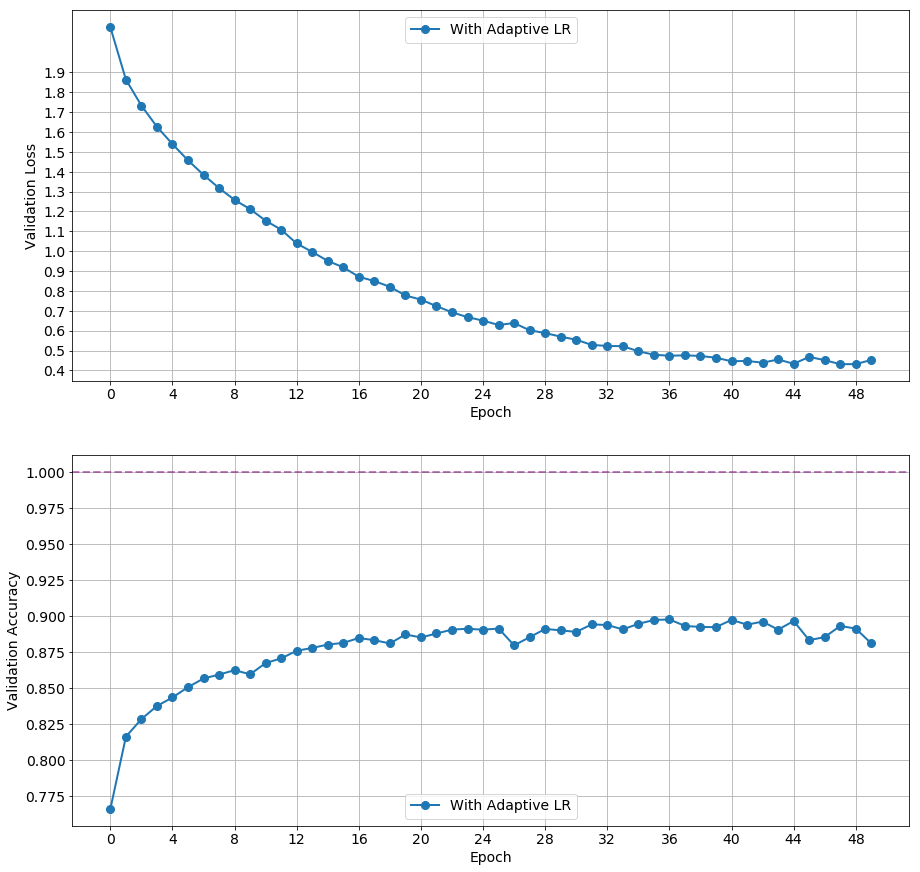

In [410]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 100

results = {
#     "Simple": fc_nn.results,
#     "With Regularization": fc_nn_r.results,
    "With Adaptive LR": fc_nn_alr.results,
}

fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(2, 1, 1)
ax.set(xlabel='Epoch', ylabel='Validation Loss')
ax.set_yticks(np.arange(0, 2, 0.1))

for i, ((model_name, result), marker) in enumerate(zip(results.items(), ['o', 's', '^'])):
    x = [int(n) for n in result.keys()]
    y = [v['val_loss'] for v in result.values()]

    ax.plot(x, y, '-{}'.format(marker), markersize=8, label=model_name, linewidth=2)
    ax.set_xticks(x[::4])
    ax.set_xticklabels(x[::4])

ax.grid()
ax.legend(loc='upper center')

ax = fig.add_subplot(2, 1, 2)
ax.set(xlabel='Epoch', ylabel='Validation Accuracy')
ax.set_yticks(np.arange(0.2, 1.04, 0.025))
ax.axhline(1, ls='--', color='purple', linewidth=2, alpha=0.5)

for i, ((model_name, result), marker) in enumerate(zip(results.items(), ['o', 's', '^'])):
    x = [int(n) for n in result.keys()]
    y = [v['val_acc'] for v in result.values()]

    ax.plot(x, y, '-{}'.format(marker), markersize=8, label=model_name, linewidth=2)
    ax.set_xticks(x[::4])
    ax.set_xticklabels(x[::4])

ax.grid()
ax.legend(loc='lower center')

plt.show()